# Data Processing


In [1]:
#%pip install wfdb

In [2]:
#%pip install keras

In [3]:
#%pip install tensorflow

In [4]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, re, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models



# Visualization of the Data Provided

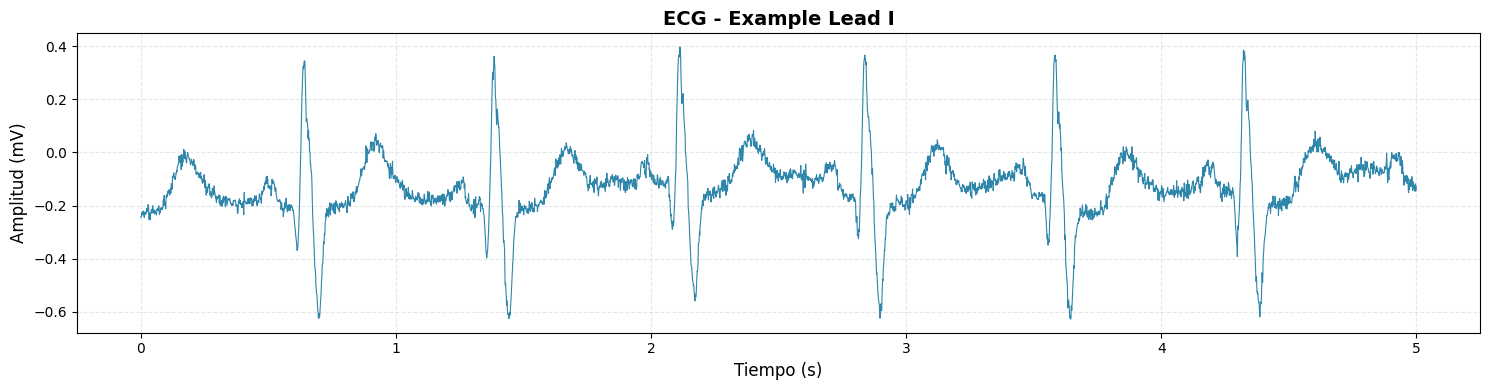

In [5]:

record = wfdb.rdrecord('Data/ptb-diagnostic-ecg-database/patient001/s0010_re')
signal = record.p_signal
fs = record.fs  

channel = 0
duration_sec = 5
lead_name = 'Example Lead I'

samples = int(duration_sec * fs)
time = np.arange(samples) / fs

plt.figure(figsize=(15, 4))
plt.plot(time, signal[:samples, channel], linewidth=0.8, color='#2E86AB')
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Amplitud (mV)', fontsize=12)
plt.title(f'ECG - {lead_name or record.sig_name[channel]}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

Form of the signal: (38400, 15)
Channel: ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'vx', 'vy', 'vz']


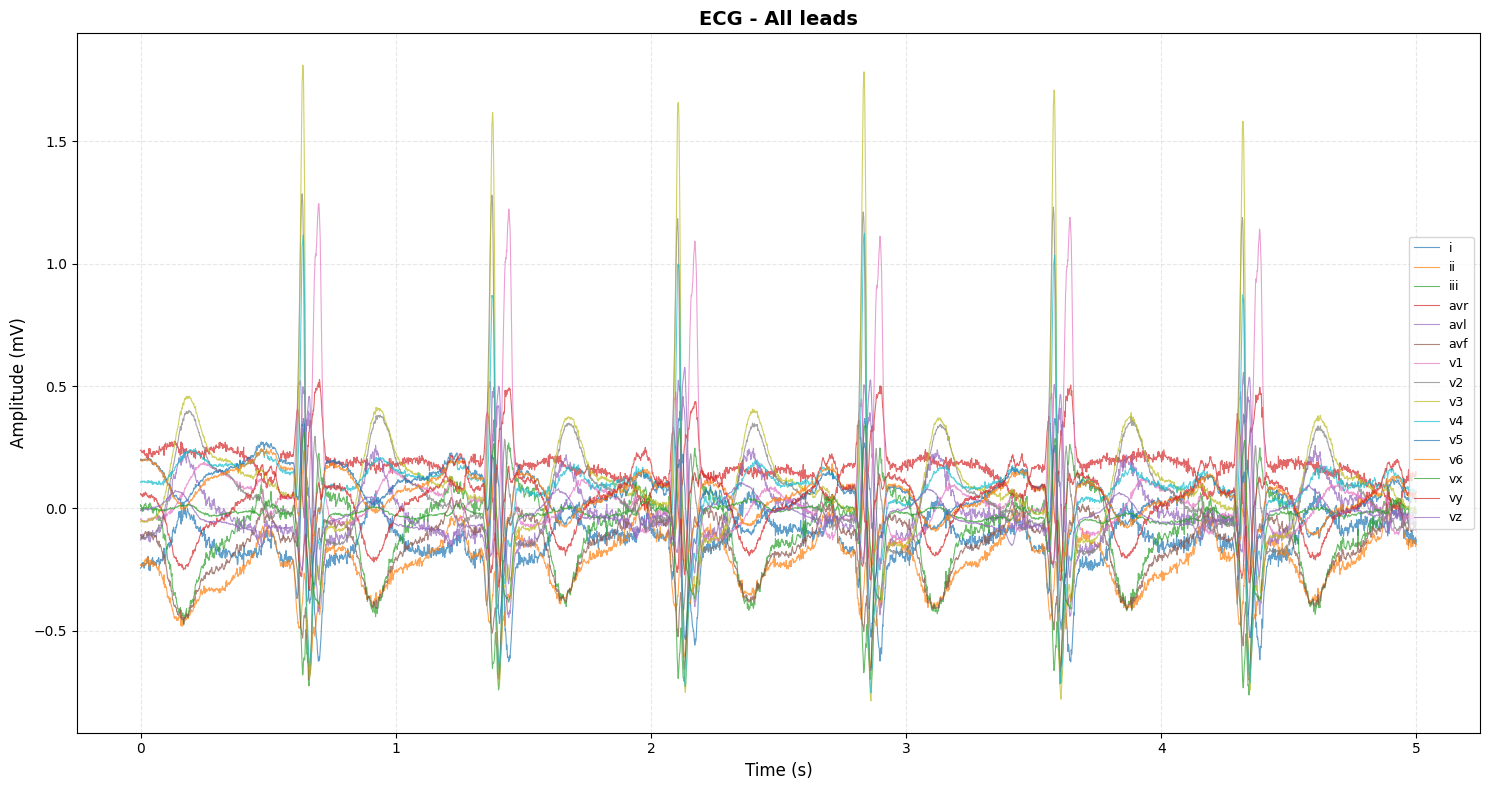

In [6]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Leer un registro
record = wfdb.rdrecord('Data/ptb-diagnostic-ecg-database/patient001/s0010_re')
signal = record.p_signal
fs = record.fs

print("Form of the signal:", signal.shape)
print("Channel:", record.sig_name)

# Configuración
duration_sec = 5
samples = int(duration_sec * fs)
time = np.arange(samples) / fs
plt.figure(figsize=(15, 8))

for i in range(signal.shape[1]):
    plt.plot(time, signal[:samples, i], linewidth=0.8, label=record.sig_name[i], alpha=0.7)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.title('ECG - All leads', fontsize=14, fontweight='bold')
plt.legend(loc='right', fontsize=9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

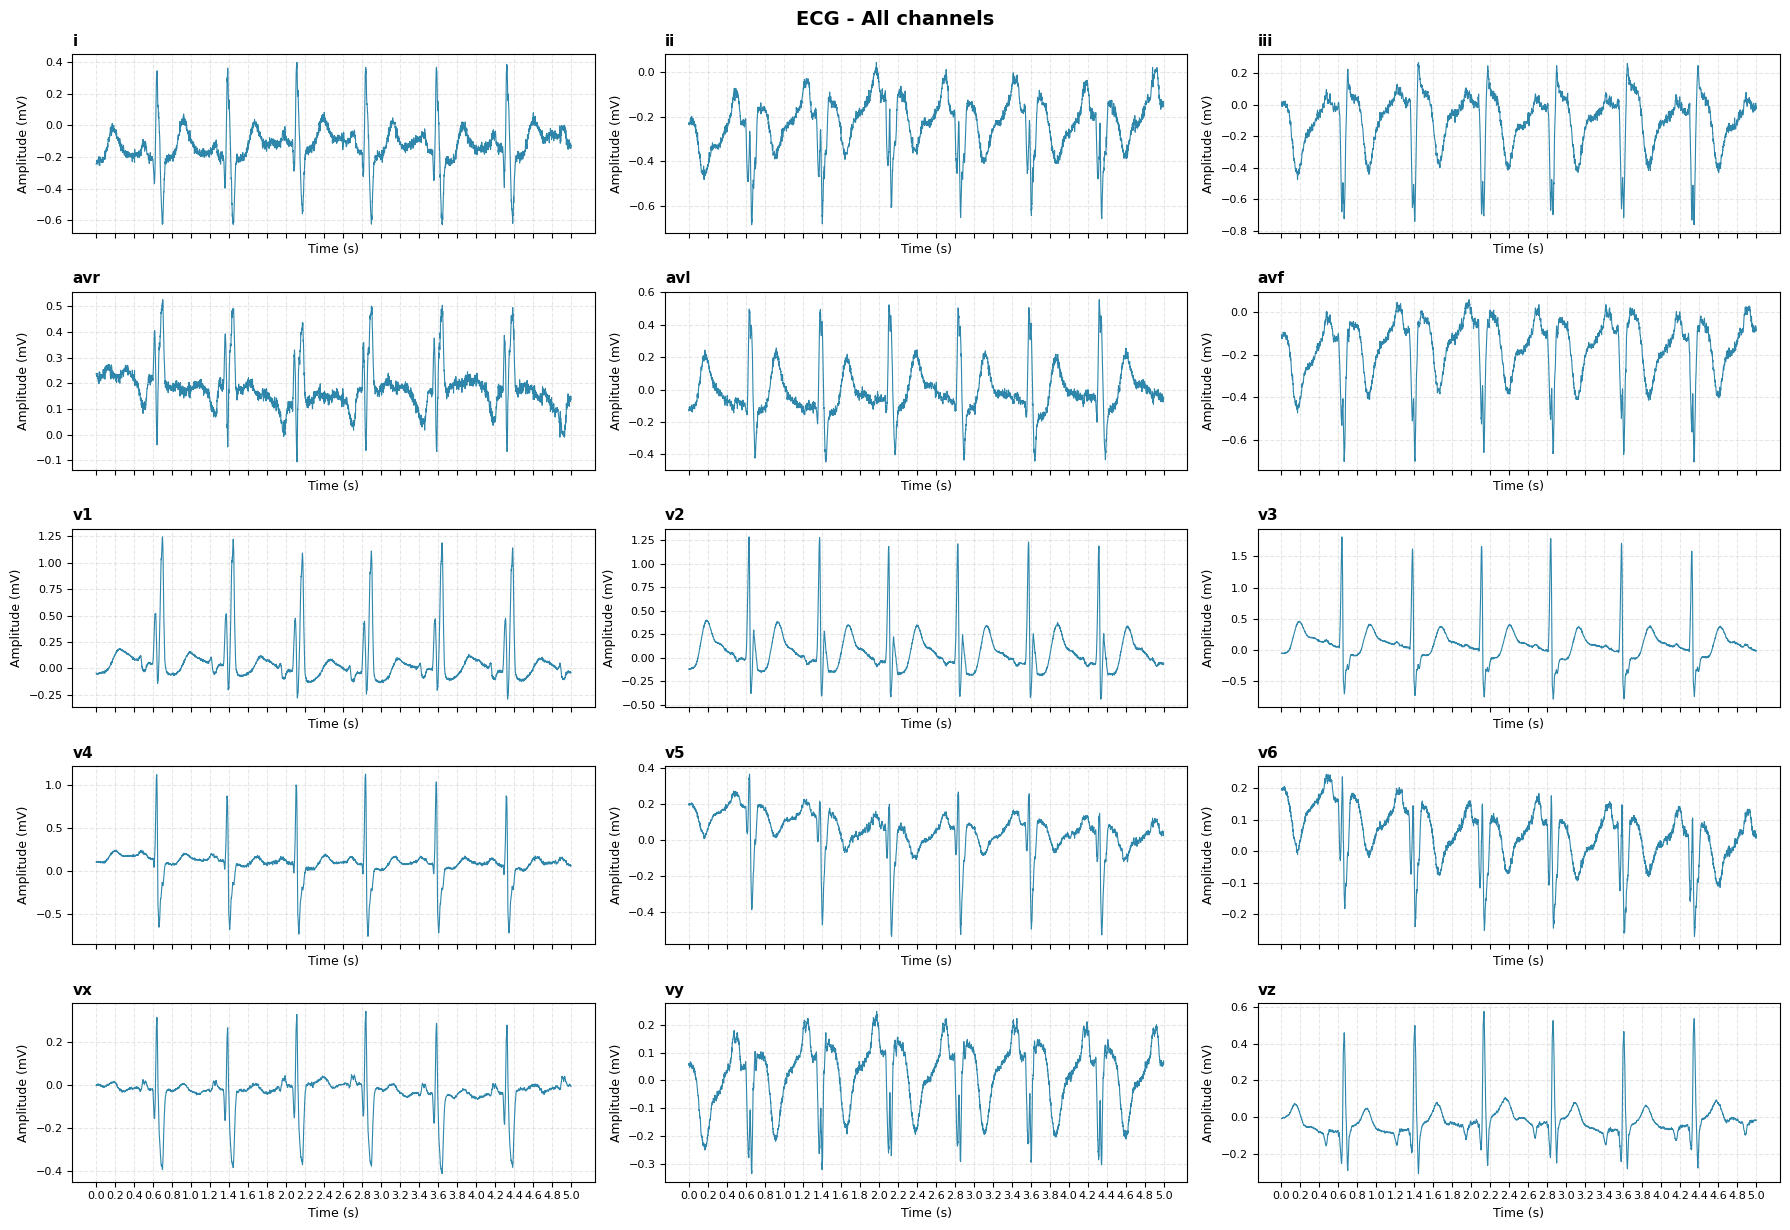

In [7]:

record = wfdb.rdrecord('Data/ptb-diagnostic-ecg-database/patient001/s0010_re')
signal = record.p_signal
fs = record.fs  

duration_sec = 5
samples = int(duration_sec * fs)
time = np.arange(samples) / fs

n_channels = signal.shape[1]


n_cols = 3 
n_rows = int(np.ceil(n_channels / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 2.5*n_rows), sharex=True, sharey=False)
axes = axes.flatten()  

for i in range(n_channels):
    axes[i].plot(time, signal[:samples, i], linewidth=0.8, color='#2E86AB')
    axes[i].set_ylabel('Amplitude (mV)', fontsize=9)
    axes[i].set_xlabel('Time (s)', fontsize=9)
    axes[i].set_title(record.sig_name[i], fontsize=11, loc='left', fontweight='bold')
    axes[i].set_xticks(np.arange(0, duration_sec + 0.2, 0.2))
    axes[i].grid(True, alpha=0.3, linestyle='--')
    axes[i].tick_params(axis='both', labelsize=8)


plt.suptitle('ECG - All channels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
base_dir = 'Data/ptb-diagnostic-ecg-database' 
out_signals = 'Data/signals_npy'
os.makedirs(out_signals, exist_ok=True)

In [9]:
def to_key(s):
    s = s.strip('# ').lower()
    s = s.replace('(localization)','localization').replace('(at rest)','at_rest').replace('(load)','load')
    return re.sub(r'[^a-z0-9]+','_',s).strip('_')

def parse_comments(comments):
    d={}
    for c in comments or []:
        if ':' in c:
            k,v = c.split(':',1)
            d[to_key(k)] = v.strip()
    return d

def map_primary_label(meta):
    raw = (meta.get('reason_for_admission') or meta.get('diagnose') or '').lower()
    raw = raw.replace('heartfailure','heart failure').replace('arrhythmia','dysrhythmia')
    if 'healthy control' in raw: return 'Healthy controls'
    if 'myocardial infarction' in raw: return 'Myocardial infarction'
    if 'cardiomyopathy' in raw or 'heart failure' in raw: return 'Cardiomyopathy/Heart failure'
    if 'bundle branch block' in raw: return 'Bundle branch block'
    if 'dysrhythmia' in raw: return 'Dysrhythmia'
    if 'hypertrophy' in raw: return 'Myocardial hypertrophy'
    if 'valvular' in raw: return 'Valvular heart disease'
    if 'myocarditis' in raw: return 'Myocarditis'
    return 'Miscellaneous'


In [10]:

rows=[]
for patient in sorted(os.listdir(base_dir)):
    pdir = os.path.join(base_dir, patient)
    if not os.path.isdir(pdir):
        continue

    for f in sorted(os.listdir(pdir)):
        if not f.endswith('.hea'):
            continue

        rec = f[:-4]
        stem = os.path.join(pdir, rec)

        try:
            hdr = wfdb.rdheader(stem)
            recd = wfdb.rdrecord(stem)
            meta = parse_comments(hdr.comments)
            label = map_primary_label(meta)

            sig = recd.p_signal
            n_samples, n_leads = sig.shape
            npy_path = os.path.join(out_signals, f'{patient}_{rec}.npy')
            np.save(npy_path, sig)

            def num(x): 
                return pd.to_numeric(x, errors='coerce')
            rows.append({
                'patient_id': patient,
                'record': rec,
                'base_path': stem,
                'n_samples': n_samples,
                'n_leads': n_leads,
                'fs': hdr.fs,
                'sig_name': hdr.sig_name,
                'signal_path': npy_path,
                'diagnosis_class': label,
                'is_MI': 1 if label == 'Myocardial infarction' else 0,
                'age': num(meta.get('age')),
                'sex': meta.get('sex'),
                'reason_for_admission': meta.get('reason_for_admission'),
                'acute_infarction_localization': meta.get('acute_infarction_localization'),
                'former_infarction_localization': meta.get('former_infarction_localization'),
                'additional_diagnoses': meta.get('additional_diagnoses'),
                'smoker': 1 if str(meta.get('smoker','')).lower().startswith('y') else 0
            })

        except Exception as e:
            print( stem, e)

df = pd.DataFrame(rows)
print(df.shape)
df.head()

(549, 17)


,patient_id,record,base_path,n_samples,n_leads,fs,sig_name,signal_path,diagnosis_class,is_MI,age,sex,reason_for_admission,acute_infarction_localization,former_infarction_localization,additional_diagnoses,smoker
0,patient001,s0010_re,Data/ptb-diagnostic-ecg-database\patient001\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0010_re.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
1,patient001,s0014lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0014lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
2,patient001,s0016lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0016lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
3,patient002,s0015lre,Data/ptb-diagnostic-ecg-database\patient002\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient002_s0015lre.npy,Myocardial infarction,1,58.0,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",1
4,patient003,s0017lre,Data/ptb-diagnostic-ecg-database\patient003\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient003_s0017lre.npy,Myocardial infarction,1,63.0,male,Myocardial infarction,infero-postero-lateral,no,no,1


In [11]:
df['diagnosis_class'].value_counts()

diagnosis_class
Myocardial infarction           368
Healthy controls                 80
Miscellaneous                    31
Cardiomyopathy/Heart failure     20
Bundle branch block              17
Dysrhythmia                      16
Myocardial hypertrophy            7
Valvular heart disease            6
Myocarditis                       4
Name: count, dtype: int64

In [15]:
df['diagnosis_class'].value_counts()

diagnosis_class
Myocardial infarction           368
Healthy controls                 80
Miscellaneous                    31
Cardiomyopathy/Heart failure     20
Bundle branch block              17
Dysrhythmia                      16
Name: count, dtype: int64

In [17]:
df = pd.DataFrame(rows)
print(df.shape)
print(df.head())

(549, 17)
   patient_id    record                                          base_path  \
0  patient001  s0010_re  Data/ptb-diagnostic-ecg-database\patient001\s0...   
1  patient001  s0014lre  Data/ptb-diagnostic-ecg-database\patient001\s0...   
2  patient001  s0016lre  Data/ptb-diagnostic-ecg-database\patient001\s0...   
3  patient002  s0015lre  Data/ptb-diagnostic-ecg-database\patient002\s0...   
4  patient003  s0017lre  Data/ptb-diagnostic-ecg-database\patient003\s0...   

   n_samples  n_leads    fs  \
0      38400       15  1000   
1     115200       15  1000   
2     115200       15  1000   
3     115200       15  1000   
4     115200       15  1000   

                                            sig_name  \
0  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...   
1  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...   
2  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...   
3  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...   
4  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...  

In [18]:
df['diagnosis_class'].value_counts()

diagnosis_class
Myocardial infarction           368
Healthy controls                 80
Miscellaneous                    31
Cardiomyopathy/Heart failure     20
Bundle branch block              17
Dysrhythmia                      16
Myocardial hypertrophy            7
Valvular heart disease            6
Myocarditis                       4
Name: count, dtype: int64

In [19]:
df = df[df['diagnosis_class'] != 'Myocarditis']
df = df[df['diagnosis_class'] != 'Valvular heart disease']
df = df[df['diagnosis_class'] != 'Myocardial hypertrophy']

In [20]:
df['diagnosis_class'].value_counts()

diagnosis_class
Myocardial infarction           368
Healthy controls                 80
Miscellaneous                    31
Cardiomyopathy/Heart failure     20
Bundle branch block              17
Dysrhythmia                      16
Name: count, dtype: int64

In [21]:
df.head()

,patient_id,record,base_path,n_samples,n_leads,fs,sig_name,signal_path,diagnosis_class,is_MI,age,sex,reason_for_admission,acute_infarction_localization,former_infarction_localization,additional_diagnoses,smoker
0,patient001,s0010_re,Data/ptb-diagnostic-ecg-database\patient001\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0010_re.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
1,patient001,s0014lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0014lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
2,patient001,s0016lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0016lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
3,patient002,s0015lre,Data/ptb-diagnostic-ecg-database\patient002\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient002_s0015lre.npy,Myocardial infarction,1,58.0,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",1
4,patient003,s0017lre,Data/ptb-diagnostic-ecg-database\patient003\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient003_s0017lre.npy,Myocardial infarction,1,63.0,male,Myocardial infarction,infero-postero-lateral,no,no,1


In [22]:

df_unique = df.groupby('patient_id')['diagnosis_class'].first().reset_index()
df_unique['diagnosis_class'].value_counts()

diagnosis_class
Myocardial infarction           148
Healthy controls                 52
Miscellaneous                    26
Cardiomyopathy/Heart failure     18
Bundle branch block              15
Dysrhythmia                      14
Name: count, dtype: int64

In [23]:
df.columns

Index(['patient_id', 'record', 'base_path', 'n_samples', 'n_leads', 'fs',
       'sig_name', 'signal_path', 'diagnosis_class', 'is_MI', 'age', 'sex',
       'reason_for_admission', 'acute_infarction_localization',
       'former_infarction_localization', 'additional_diagnoses', 'smoker'],
      dtype='object')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 0 to 548
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      532 non-null    object 
 1   record                          532 non-null    object 
 2   base_path                       532 non-null    object 
 3   n_samples                       532 non-null    int64  
 4   n_leads                         532 non-null    int64  
 5   fs                              532 non-null    int64  
 6   sig_name                        532 non-null    object 
 7   signal_path                     532 non-null    object 
 8   diagnosis_class                 532 non-null    object 
 9   is_MI                           532 non-null    int64  
 10  age                             515 non-null    float64
 11  sex                             532 non-null    object 
 12  reason_for_admission            532 non-n

## Null analysis


In [25]:
null_counts = df.isna().sum().sort_values(ascending=False)
null_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False)
null_report = pd.DataFrame({"n_nulls": null_counts, "percentage_nulls": null_pct})
print("\n Nulls per column:")
display(null_report)


 Nulls per column:


,n_nulls,percentage_nulls
age,17,3.2
patient_id,0,0.0
is_MI,0,0.0
additional_diagnoses,0,0.0
former_infarction_localization,0,0.0
acute_infarction_localization,0,0.0
reason_for_admission,0,0.0
sex,0,0.0
diagnosis_class,0,0.0
record,0,0.0


In [26]:
print("\n Unique Patients:", df['patient_id'].nunique())
print("\n Total records:", len(df))
print("\n Sampling frequency (fs) — count:")
print(df['fs'].value_counts(dropna=False))


 Unique Patients: 273

 Total records: 532

 Sampling frequency (fs) — count:
fs
1000    532
Name: count, dtype: int64


In [27]:
df['sex'].value_counts(dropna=False)

sex
male      379
female    143
n/a         9
            1
Name: count, dtype: int64

In [28]:
suspect_strings = ['n/a', 'na', 'Na', 'NA', 'nan', 'Nan', 'None', '', ' ', 'unknown', 'Unknown', 'N/A']
for col in df.select_dtypes(include='object').columns:
    mask = df[col].astype(str).str.strip().isin(suspect_strings)
    count = mask.sum()
    if count > 0:
        print(f"{col}: {count} null-like values")


sex: 10 null-like values
reason_for_admission: 27 null-like values
acute_infarction_localization: 28 null-like values
former_infarction_localization: 41 null-like values
additional_diagnoses: 43 null-like values


In [29]:
jut = df[(df['former_infarction_localization'] == 'n/a') & (df['acute_infarction_localization']=='n/a')]

In [30]:
df['additional_diagnoses'].value_counts()

additional_diagnoses
no                                                                                                                                  160
Arterial hypertension                                                                                                                29
n/a                                                                                                                                  27
Hypercholesterinemia                                                                                                                 18
unknown                                                                                                                              16
                                                                                                                                   ... 
Palpitation, Obesity, EP-Lab: Inducible ectopic atrial tachycardia                                                                    1
Coronary heart disease, Art

In [31]:
jut.index

Index([333, 338, 348, 355, 356, 358, 367, 375, 377, 378, 395, 397, 398, 406,
       407, 412, 416, 417, 419, 421, 429, 519, 522, 523, 524, 530, 536],
      dtype='int64')

In [32]:
df.drop(index=jut.index, inplace=True)


In [34]:
suspect_strings = ['n/a', 'na', 'Na', 'NA', 'nan', 'Nan', 'None', '', ' ', 'unknown', 'Unknown', 'N/A']
for col in df.select_dtypes(include='object').columns:
    mask = df[col].astype(str).str.strip().isin(suspect_strings)
    count = mask.sum()
    if count > 0:
        print(f"{col}: {count} null-like values")


acute_infarction_localization: 1 null-like values
former_infarction_localization: 14 null-like values
additional_diagnoses: 16 null-like values


In [36]:
df = df[df['sex'] != 'n/a']


In [38]:
df = df[df['acute_infarction_localization'] !='unknown']


In [39]:
suspect_strings = ['n/a', 'na', 'Na', 'NA', 'nan', 'Nan', 'None', '', ' ', 'unknown', 'Unknown', 'N/A']
for col in df.select_dtypes(include='object').columns:
    mask = df[col].astype(str).str.strip().isin(suspect_strings)
    count = mask.sum()
    if count > 0:
        print(f"{col}: {count} null-like values")

former_infarction_localization: 13 null-like values
additional_diagnoses: 16 null-like values


In [46]:
df = df[df['former_infarction_localization'] != 'unknown']

In [48]:
df = df[df['additional_diagnoses'] != 'unknown']

In [49]:
suspect_strings = ['n/a', 'na', 'Na', 'NA', 'nan', 'Nan', 'None', '', ' ', 'unknown', 'Unknown', 'N/A']
for col in df.select_dtypes(include='object').columns:
    mask = df[col].astype(str).str.strip().isin(suspect_strings)
    count = mask.sum()
    if count > 0:
        print(f"{col}: {count} null-like values")

In [40]:
null_counts = df.isna().sum().sort_values(ascending=False)
null_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False)
null_report = pd.DataFrame({"n_nulls": null_counts, "percentage_nulls": null_pct})
print("\n Nulls per column:")
display(null_report)


 Nulls per column:


,n_nulls,percentage_nulls
age,7,1.39
patient_id,0,0.00
is_MI,0,0.00
additional_diagnoses,0,0.00
former_infarction_localization,0,0.00
acute_infarction_localization,0,0.00
reason_for_admission,0,0.00
sex,0,0.00
diagnosis_class,0,0.00
record,0,0.00


In [41]:
df.dropna(inplace=True)

In [42]:
null_counts = df.isna().sum().sort_values(ascending=False)
null_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False)
null_report = pd.DataFrame({"n_nulls": null_counts, "percentage_nulls": null_pct})
print("\n Nulls per column:")
display(null_report)


 Nulls per column:


,n_nulls,percentage_nulls
patient_id,0,0.0
is_MI,0,0.0
additional_diagnoses,0,0.0
former_infarction_localization,0,0.0
acute_infarction_localization,0,0.0
reason_for_admission,0,0.0
sex,0,0.0
age,0,0.0
diagnosis_class,0,0.0
record,0,0.0


## Visualizations

C:\Users\karla\AppData\Local\Temp\ipykernel_12636\1529003087.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


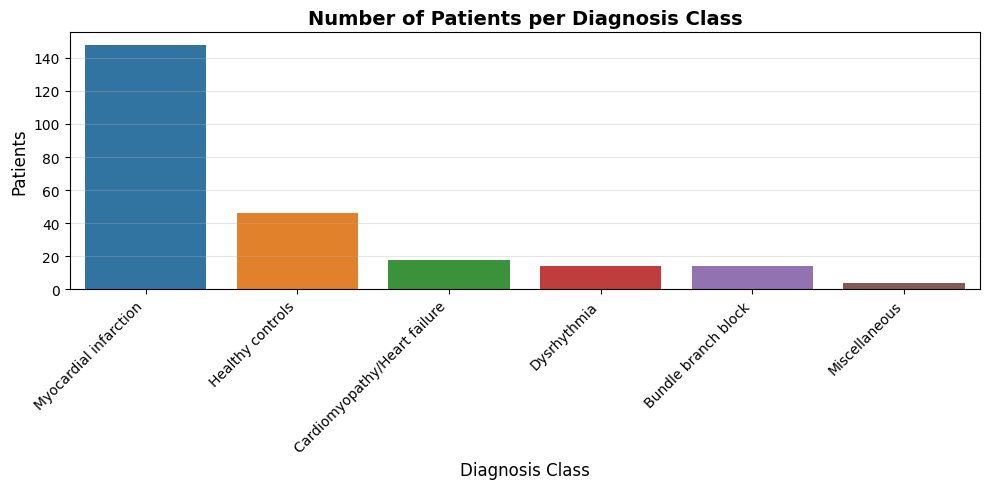

In [43]:

by_patient = df.groupby('patient_id', as_index=False)['diagnosis_class'].first()

plt.figure(figsize=(10,5))
sns.countplot(
    data=by_patient,
    x='diagnosis_class',
    order=by_patient['diagnosis_class'].value_counts().index,
    palette='tab10'
)

plt.title('Number of Patients per Diagnosis Class', fontsize=14, fontweight='bold')
plt.xlabel('Diagnosis Class', fontsize=12)
plt.ylabel('Patients', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [44]:
df.head()

,patient_id,record,base_path,n_samples,n_leads,fs,sig_name,signal_path,diagnosis_class,is_MI,age,sex,reason_for_admission,acute_infarction_localization,former_infarction_localization,additional_diagnoses,smoker
0,patient001,s0010_re,Data/ptb-diagnostic-ecg-database\patient001\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0010_re.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
1,patient001,s0014lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0014lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
2,patient001,s0016lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0016lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
3,patient002,s0015lre,Data/ptb-diagnostic-ecg-database\patient002\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient002_s0015lre.npy,Myocardial infarction,1,58.0,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",1
4,patient003,s0017lre,Data/ptb-diagnostic-ecg-database\patient003\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient003_s0017lre.npy,Myocardial infarction,1,63.0,male,Myocardial infarction,infero-postero-lateral,no,no,1


In [51]:
df.shape

(469, 17)